In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

For this homework, we only want to use a subset of data. 

Preparation:
<li>Keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
<li>Fill missing values with zeros.
<li>Apply the log transform to median_house_value.
<li>Do train/validation/test split with 60%/20%/20% distribution.
<li>Use the train_test_split function and set the random_state parameter to 1.
<li>Use DictVectorizer(sparse=True) to turn the dataframes into matrices.


In [2]:
df = pd.read_csv('housing.csv')
df.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
10608,-117.78,33.68,14.0,1750.0,336.0,852.0,300.0,4.6793,236800.0,<1H OCEAN
15968,-122.40,37.71,40.0,1883.0,397.0,1411.0,438.0,3.0469,238000.0,NEAR BAY
20461,-118.75,34.28,22.0,3844.0,537.0,1665.0,492.0,6.2059,239900.0,<1H OCEAN
4358,-118.37,34.08,52.0,2946.0,695.0,1258.0,650.0,3.9783,374100.0,<1H OCEAN
12907,-121.33,38.60,25.0,4260.0,607.0,1635.0,640.0,6.2817,288200.0,INLAND


In [3]:
df.drop(df[~df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].index, inplace=True)
df.fillna(0, inplace=True)
df['price'] = np.log1p(df.median_house_value)
median_house_value = df.median_house_value
df.drop('median_house_value', axis=1, inplace=True)

In [4]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)
del df_train_val

def x_y_split_and_index(df, y_column):
    df.reset_index(drop=True, inplace=True)
    cols_x = df.columns[df.columns!=y_column]
    X = df[cols_x].copy()
    y = df[y_column].values
    return X, y

X_train, y_train = x_y_split_and_index(df_train, 'price')
X_test, y_test = x_y_split_and_index(df_test, 'price')
X_val, y_val = x_y_split_and_index(df_val, 'price')

In [5]:
train_dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(X_val.to_dict(orient='records'))
X_test = dv.transform(X_test.to_dict(orient='records'))

##### Question 1

Let's train a decision tree regressor to predict the median_house_value variable.<br>
Train a model with max_depth=1.<br>
Which feature is used for splitting the data?

In [6]:
from sklearn.tree import DecisionTreeRegressor

In [7]:
model = DecisionTreeRegressor(max_depth=1, random_state=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [8]:
dict(zip(df.columns[:-1], model.feature_importances_))

{'longitude': 0.0,
 'latitude': 0.0,
 'housing_median_age': 0.0,
 'total_rooms': 0.0,
 'total_bedrooms': 0.0,
 'population': 1.0,
 'households': 0.0,
 'median_income': 0.0,
 'ocean_proximity': 0.0}

##### Question 2
Train a random forest model with these parameters:
<li>n_estimators=10
<li>random_state=1
<li>n_jobs=-1 (optional - to make training faster)</li>
What's the RMSE of this model on validation?

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [10]:
model_2 = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)) 

0.24459962783255346

##### Question 3
Now let's experiment with the n_estimators parameter
<br>
Try different values of this parameter from 10 to 200 with step 10.<br>
Evaluate the model on the validation dataset.<br>
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.<br>

In [11]:
results = {}
for step in range(10, 201, 10):
    model_temp = RandomForestRegressor(n_estimators=step, n_jobs=-1, random_state=1)
    model_temp.fit(X_train, y_train)
    y_pred_tmp = model_temp.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred_tmp)), 3)
    results[step] = rmse

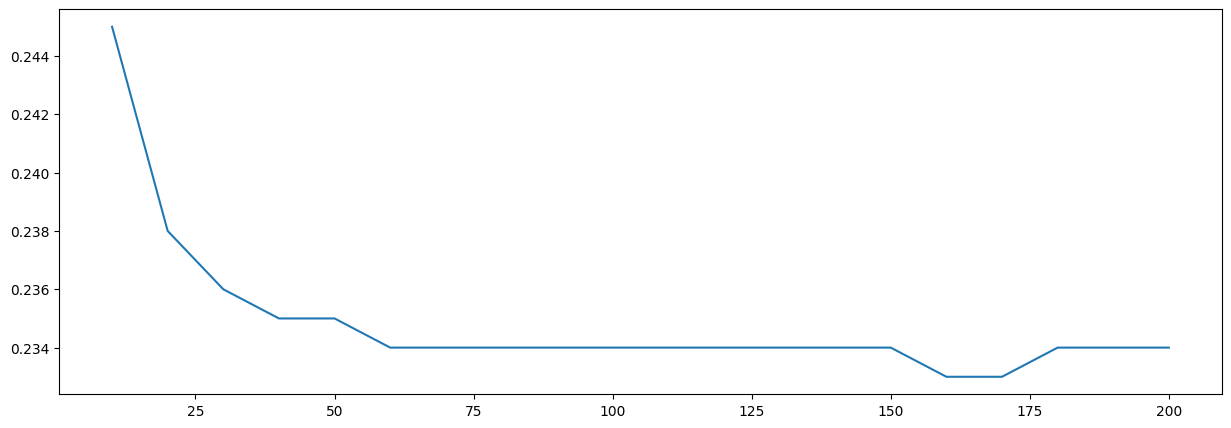

In [12]:
plt.figure(figsize=(15, 5))
_ = sns.lineplot(x=results.keys(), y=results.values())

##### Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values:
<li>try different values of n_estimators from 10 till 200 (with step 10)
<li>calculate the RMSE
<li>Fix the random seed: random_state=1</li>
What's the best max_depth, using the mean RMSE?

In [13]:
results = {}
counter = 0
for depth in [10, 15, 20, 25]:
    for estimator in range(10, 201, 10):
        model_temp = RandomForestRegressor(n_estimators=estimator, max_depth=depth, n_jobs=-1, random_state=1)
        model_temp.fit(X_train, y_train)
        y_pred_tmp = model_temp.predict(X_val)
        rmse = round(np.sqrt(mean_squared_error(y_val, y_pred_tmp)), 3)
        results[counter] = [depth, estimator, rmse]
        counter+=1
results = pd.DataFrame.from_dict(results, orient='index')
results.columns = ['depth', 'n_estimators', 'rmse']

<AxesSubplot: xlabel='n_estimators', ylabel='rmse'>

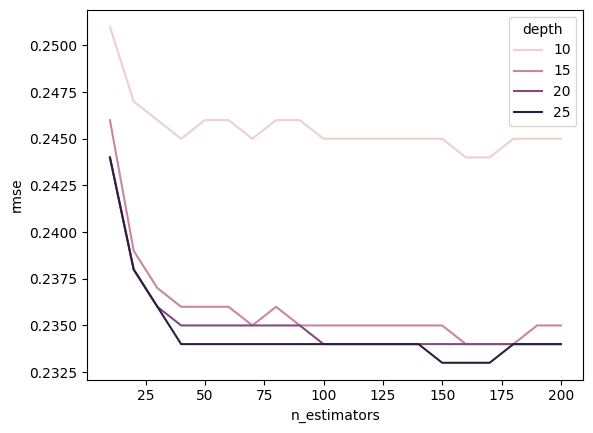

In [14]:
sns.lineplot(x='n_estimators', y='rmse', hue='depth', data=results)

##### Question 5
Train the model with these parameters:
<li>n_estimators=10,
<li>max_depth=20,
<li>random_state=1,
<li>n_jobs=-1 (optional)</li>
What's the most important feature from this model?

In [15]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
dict(zip(df.columns[:-1], model.feature_importances_))

{'longitude': 0.015043139111271224,
 'latitude': 0.030063286803328055,
 'housing_median_age': 0.10266505351248023,
 'total_rooms': 0.085853413889788,
 'total_bedrooms': 0.33548579019301683,
 'population': 0.21881985433078302,
 'households': 0.14745955406828146,
 'median_income': 0.028114716700962206,
 'ocean_proximity': 0.015433664373277032}

##### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

<li>Create DMatrix for train and validation
<li>Create a watchlist
<li>Train a model with these parameters for 100 rounds:
<br>
xgb_params = {

    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
    
}</br>
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [16]:
import xgboost

In [17]:
features = [i.replace('=<', ' less than or equal to ') for i in dv.get_feature_names_out()]
dtrain = xgboost.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgboost.DMatrix(X_val, label=y_val, feature_names=features)

In [18]:
xgb_params = {'eta': 0.3, 
              'max_depth': 6,
              'min_child_weight': 1,
              'objective': 'reg:squarederror',
              'nthread': 8,
              'seed': 1,
              'verbosity': 1}
mdl = xgboost.train(xgb_params, dtrain, num_boost_round=100)
y_pred = mdl.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.22897404244864047

In [19]:
xgb_params = {'eta': 0.1, 
              'max_depth': 6,
              'min_child_weight': 1,
              'objective': 'reg:squarederror',
              'nthread': 8,
              'seed': 1,
              'verbosity': 1}
mdl = xgboost.train(xgb_params, dtrain, num_boost_round=100)
y_pred = mdl.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2323352139407306